In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d # спойлеры
from scipy.optimize import curve_fit, least_squares

# Интерполяция
Представьте себе, у нас есть два датасета, и нас интересует их произведение. Загрузим их:

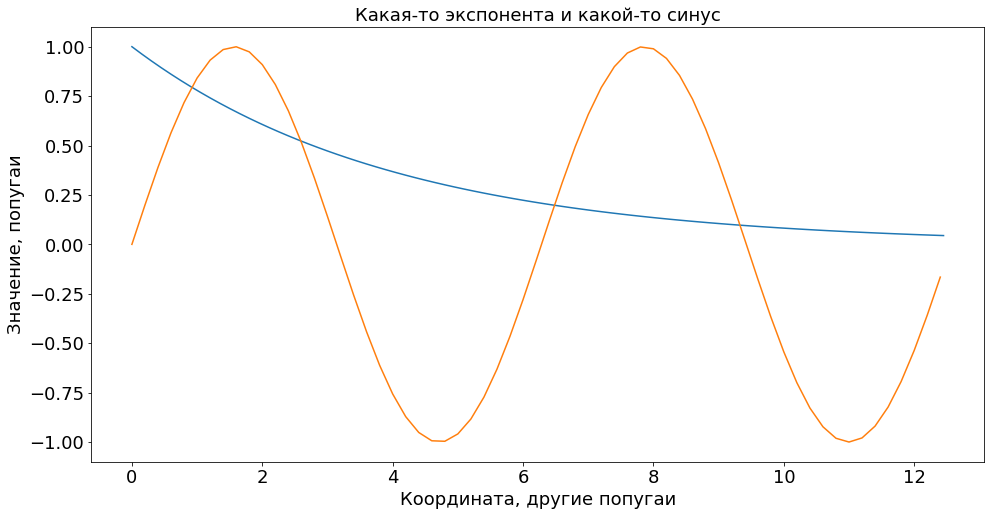

In [2]:
fig = plt.figure(figsize=(16,8))
x1, exp = np.loadtxt('data/exp.txt') # смотрите как мы можем хитро сжирать выходные данные функции
plt.plot(x1, exp)
x2, sin = np.loadtxt('data/sin.txt') # я работаю из под unix-подобной системы, в windows будет data\sin.txt
plt.plot(x2, sin)

plt.title('Какая-то экспонента и какой-то синус', fontsize=18)
plt.ylabel('Значение, попугаи', fontsize=18) # попугаи это условная единица измерения
plt.xlabel('Координата, другие попугаи',fontsize=18)      
ax=plt.gca()
ax.tick_params(labelsize=18)
plt.show()

Сможем ли мы их перемножить?

In [7]:
result = sin*exp

ValueError: operands could not be broadcast together with shapes (63,) (84,) 

Ой, кажется они разного размера... В чем дело? Давайте нарисуем поточечно:

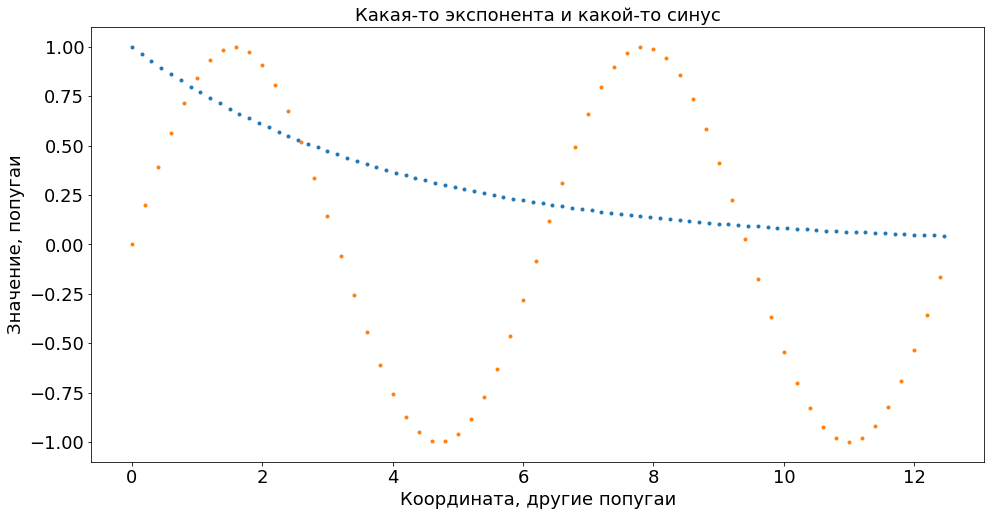

In [8]:
fig = plt.figure(figsize=(16, 8))
plt.plot(x1, exp, '.')
plt.plot(x2, sin, '.')

plt.title('Какая-то экспонента и какой-то синус', fontsize=18)
plt.ylabel('Значение, попугаи', fontsize=18)
plt.xlabel('Координата, другие попугаи', fontsize=18)
ax = plt.gca()
ax.tick_params(labelsize=18)
plt.show()

Кажется одни данные просемплированы чаще других :( <br />
Для таких (и многих других) случаев есть интерполяция:  

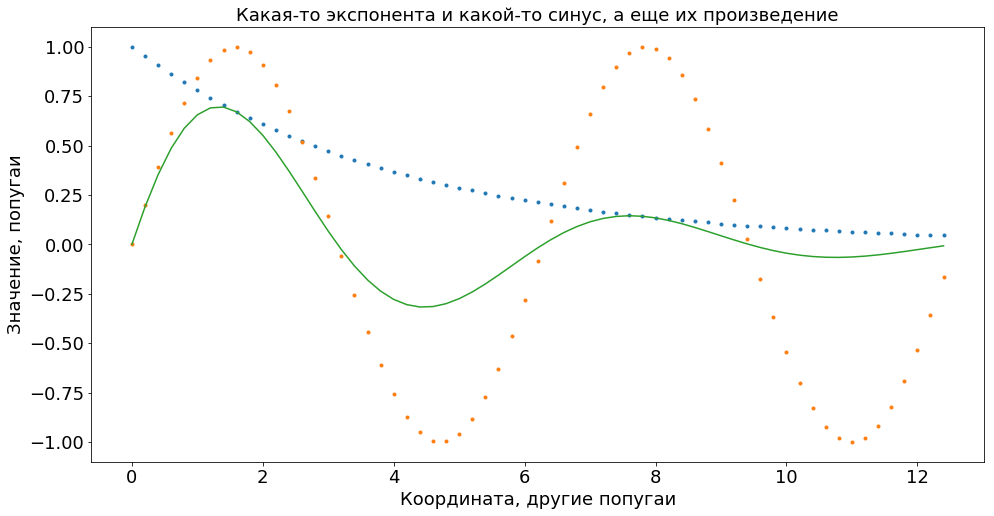

In [9]:
linear_interp = interp1d(x1, exp) # обратите внимание на самый первый cell этого файла
                                  # мы там импортировали эту функцию
                                  # не забудьте его исполнить! 
result = linear_interp(x2)*sin
fig = plt.figure(figsize=(16,8))
plt.plot(x2, linear_interp(x2), '.')
plt.plot(x2, sin, '.')
plt.plot(x2, result)


plt.title('Какая-то экспонента и какой-то синус, а еще их произведение', fontsize=18)
plt.ylabel('Значение, попугаи', fontsize=18) 
plt.xlabel('Координата, другие попугаи',fontsize=18)      
ax = plt.gca()
ax.tick_params(labelsize=18)
plt.show()

# Векторизация
Python очень плохо переносит циклы, однако, к счастью, много циклов можно просто записать векторно. Самый простой пример это банальное перемножение двух массивов, но это мы уже делали. Сейчас попробуем разобрать что-то чуть менее очевидное, например, [нормализацию](https://en.wikipedia.org/wiki/Normalization_(statistics)) данных:

In [ ]:
result_normed = (result - result.mean())/result.std() 

А как бы это выглядело в цикле?

In [42]:
summ = 0
result_normed_loop = np.copy(result)
for i in range(len(result_normed_loop)):
    summ += result_normed_loop[i]
summ = summ/len(result_normed_loop)
std = 0
for i in range(len(result_normed_loop)):
    result_normed_loop[i] = result_normed_loop[i] - summ
    std += result_normed_loop[i]**2
std = np.sqrt(std/(len(result_normed_loop)))
for i in range(len(result_normed_loop)):
    result_normed_loop[i] /= std
    
std - result.std() 

-5.551115123125783e-17

Получили то же самое! Но посмотрите сколько кода мы запихнули в одну строчку! Теперь посмотрим как это выглядит:

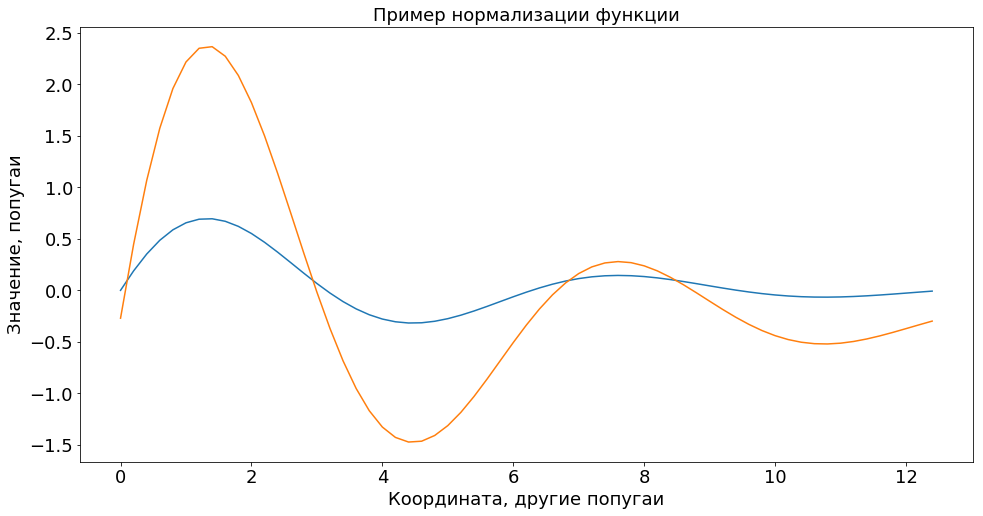

In [10]:
fig = plt.figure(figsize=(16,8))
plt.plot(x2, result)
plt.plot(x2, result_normed)

plt.title('Пример нормализации функции', fontsize=18)
plt.ylabel('Значение, попугаи', fontsize=18) 
plt.xlabel('Координата, другие попугаи',fontsize=18)      
ax = plt.gca()
ax.tick_params(labelsize=18)
plt.show()

Теперь хочу чтобы все что больше первой функции рисовалось красным, а все что меньше зеленым, но не вот таким красным который красный, а который [красивый красный](https://matplotlib.org/users/dflt_style_changes.html)!!!!! 

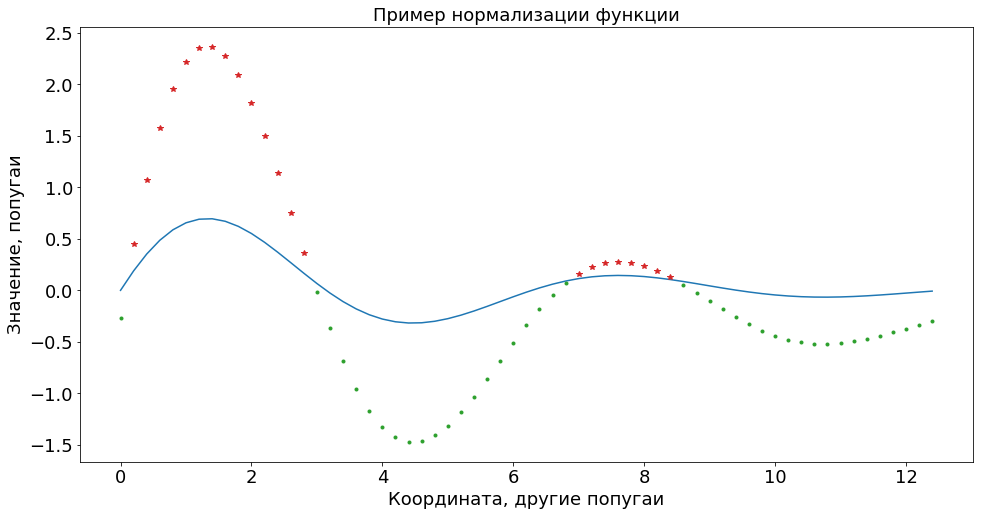

In [11]:
fig = plt.figure(figsize=(16,8))
plt.plot(x2, result, 'C0')
plt.plot(x2[result_normed>result], result_normed[result_normed>result], '*C3') # можно совмещать цвет и маркер
plt.plot(x2[result_normed<result], result_normed[result_normed<result], '.C2') 

plt.title('Пример нормализации функции', fontsize=18)
plt.ylabel('Значение, попугаи', fontsize=18) 
plt.xlabel('Координата, другие попугаи',fontsize=18)      
ax = plt.gca()
ax.tick_params(labelsize=18)
plt.show()

# Аппроксимация
Это именно то, что было в прошлом домашнем задании, только стандартными методами питона. На самом деле, аппроксимация функций &ndash; крайне обширная тема, фундамент которой составляют [методы оптимизации](https://mipt.ru/dcam/students/curriculum/prog/optimupr/metodopt.php). Мы в эту тему не будем углубляться, однако запомним основную идею: берем данные, берем модель, составляем кост-функцию (функция которая показывает разницу между данными и моделью, как правило сумма квадратов разности между каждой точкой измерения и моделью), зависящую от параметров модели, которые мы не знаем и пытаемся найти ее минимум.  

Мы будем использовать здесь библеотеку [`scipy.optimize`](https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html), в которой есть куча хороших инструментов, но сейчас нас интересует только [`scipy.curve_fit`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html). Подготовим данные: по сути, мы используем часть тех же данных, что и в прошлой лекции, только попробуем угадать модель.

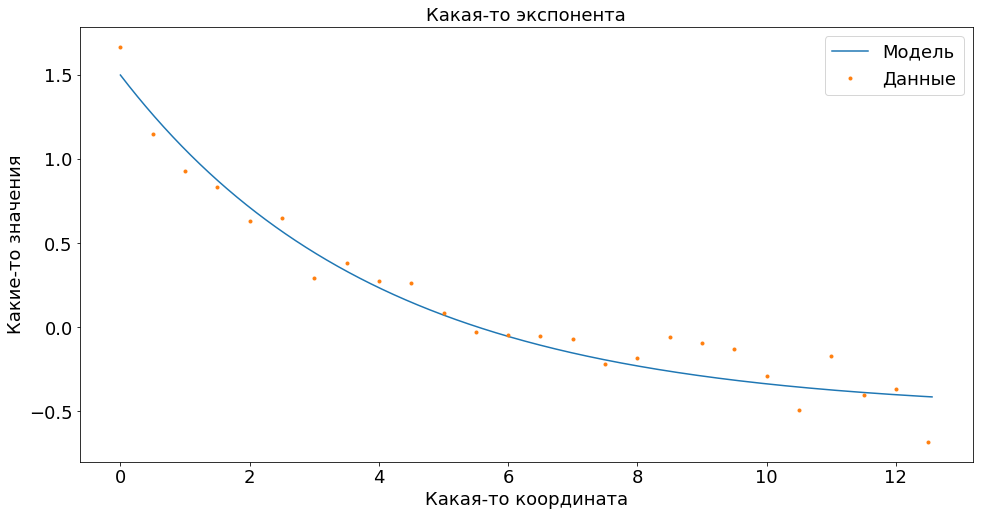

In [12]:
x = np.arange(0, 4*np.pi, 0.01)
y = -0.5 + 2*np.exp(-x/4)

y1 = y + 0.1*np.random.randn(len(y))
x_data = x[::50]
y_data = y1[::50]

plt.figure(figsize=(16, 8))
plt.plot(x, y, x_data, y_data, '.')
plt.title('Какая-то экспонента', fontsize=18)
plt.ylabel('Какие-то значения', fontsize=18)
plt.xlabel('Какая-то координата', fontsize=18)
plt.legend(['Модель', 'Данные'], fontsize=18)
ax = plt.gca()
ax.tick_params(labelsize=18)
plt.show()

Составим модель:

In [13]:
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

Попробуем использовать функцию `curve_fit`:

Какие она принимает аргументы? Модель, зависящая от парметров; данные по x и по y и p0 &ndash; изначальное предположение о параметрах (т.е. начальное предположение выглдяит так: $1\cdot exp(-1\cdot x) + c$ при `p0 = [1, 1, 1]`)

In [14]:
params, cov = curve_fit(func, x_data, y_data, p0=[1, 1, 1])
print(params)

[ 1.92355294  0.25062013 -0.4544809 ]


Что мы получили на выходе? Что за вектор `params`? Это как раз таки вектор из `[a, b, c]`, то есть такие параметры, при которых эта функция будет наиболее похожа на данные. Давайте нарисуем:

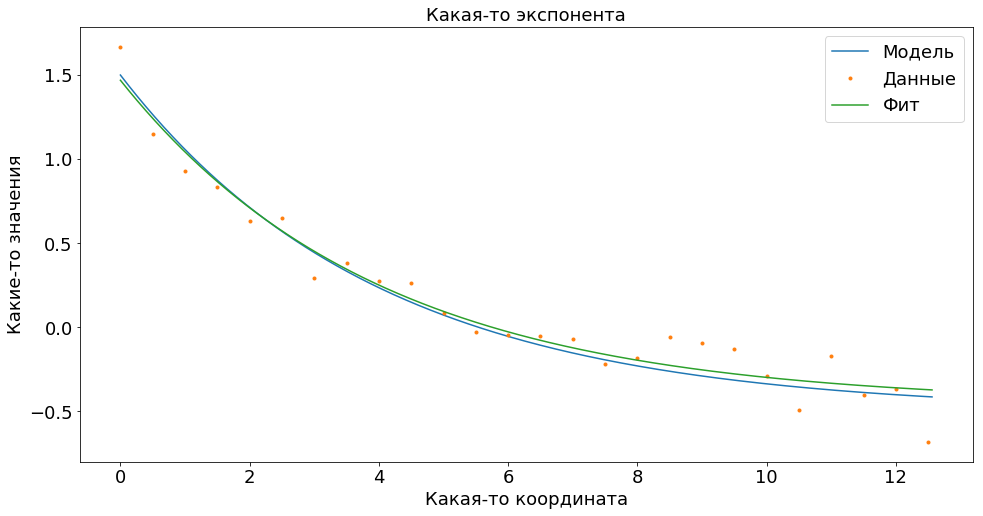

In [15]:
plt.figure(figsize=(16, 8))
plt.plot(x, y, x[::50], y1[::50], '.', x, func(x, *params)) # то же самое что и func(x, params[0], \
                                                            #                        params[1], params[2])
plt.title('Какая-то экспонента', fontsize=18)
plt.ylabel('Какие-то значения', fontsize=18)
plt.xlabel('Какая-то координата', fontsize=18)
plt.legend(['Модель', 'Данные', 'Фит'], fontsize=18)
ax = plt.gca()
ax.tick_params(labelsize=18)
plt.show()

Кажется, вполне неплохо! Особенно, учитывая что у нас там не самый маленький шум. 

**Pro tip**: Такие фиты крайне чувствительны к количеству аргументов: к примеру, если мы забудем или вообще не будем знать, что у нас аргумент экспоненты на что-то умножен, то получится полная дичь. Лучше про это не забывать!

Однако, на выходе функции мы еще какой-то параметр `cov`. Давайте разберемся что это и зачем нам это нужно!
Это [ковариация](https://www.quora.com/What-is-an-intuitive-explanation-of-covariance) параметров. Зачем она нам? Для начала, мы можем [посчитать](https://en.wikipedia.org/wiki/Covariance#Properties) стандартное отклонение:

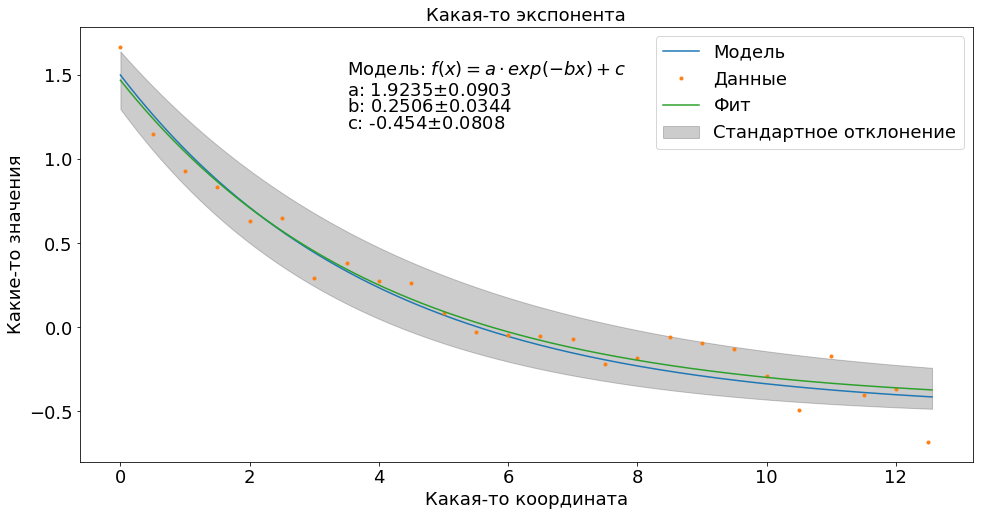

In [16]:
stds = np.sqrt(np.diag(cov)) # корень из COV(J, J)

plt.figure(figsize=(16, 8))
plt.plot(x, y, x[::50], y1[::50], '.', x, func(x, *params))
plt.title('Какая-то экспонента', fontsize=18)
plt.ylabel('Какие-то значения', fontsize=18)
plt.xlabel('Какая-то координата', fontsize=18)

ax = plt.gca()
ax.tick_params(labelsize=18)
#  .text(х, y,  'Текст') - где x  и y - позиция по осям 
plt.text(3.5,1.5, 'Модель: 'r'$f(x) = a\cdot exp(-bx) + c$', fontsize = 18)
plt.text(3.5,1.38, 'a: ' + str(params[0])[:6] + r'$\pm $' + str(stds[0])[:6], fontsize = 18) 
plt.text(3.5,1.28, 'b: ' + str(params[1])[:6] + r'$\pm $' + str(stds[1])[:6], fontsize = 18)
plt.text(3.5,1.18, 'c: ' + str(params[2])[:6] + r'$\pm $' + str(stds[2])[:6], fontsize = 18)
                                                        # \ - перенос на следующую строку
plt.fill_between(x, func(x, *(params - stds*(1, -1, 1))), \
                 func(x, *(params + stds*(1, -1, 1))), \
                 alpha=0.2, edgecolor='k', facecolor = 'k') # рисование красивых еррорбаров, эдвенсед фича

plt.legend(['Модель', 'Данные', 'Фит', 'Стандартное отклонение'], fontsize=18)
plt.show()

Что такое *стандратное отклонение* или $1\sigma$ простыми словами? Это область в которую должно попасть [68.2% от всех точек](https://ru.wikipedia.org/wiki/%D0%A1%D1%80%D0%B5%D0%B4%D0%BD%D0%B5%D0%BA%D0%B2%D0%B0%D0%B4%D1%80%D0%B0%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B5_%D0%BE%D1%82%D0%BA%D0%BB%D0%BE%D0%BD%D0%B5%D0%BD%D0%B8%D0%B5#/media/File:Standard_deviation_diagram_(decimal_comma).svg), часто используют так же критерии 2 или 3 сигма.

Ладно, это был легкий пример, давайте что-нибудь поинтереснее придумаем:

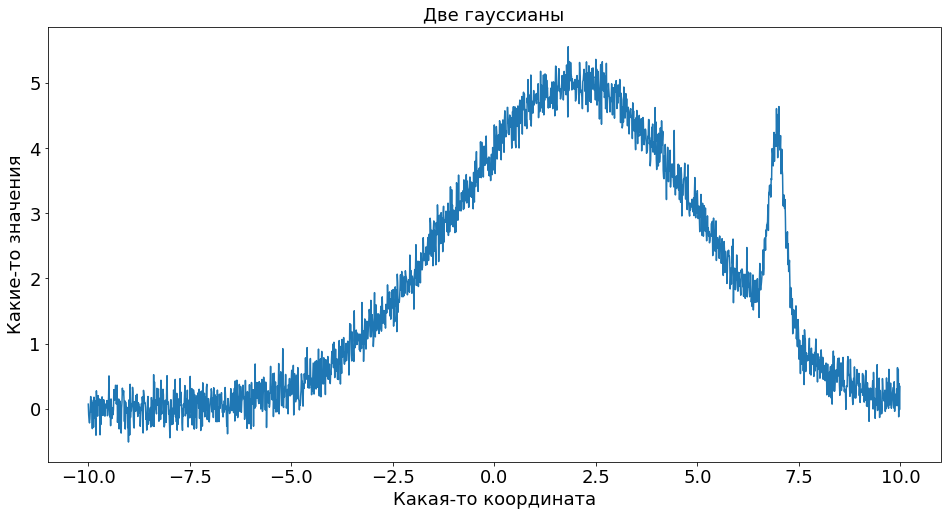

In [12]:
x3 = np.arange(-10, 10, 0.01)
y3 = 5*np.exp(-1/2*((x3 - 2)/3)**2) + 3*np.exp(-1/2*((x3 - 7 - 0.1*np.random.randn(1))/0.2)**2) + 0.2*np.random.randn(len(x3))

plt.figure(figsize=(16, 8))
plt.plot(x3, y3)
plt.title('Две гауссианы', fontsize=18)
plt.ylabel('Какие-то значения', fontsize=18)
plt.xlabel('Какая-то координата', fontsize=18)
ax = plt.gca()
ax.tick_params(labelsize=18)
plt.show()

Нам ну очень нужно узнать, где находится центр второй гауссианы. Нет, мы конечно можем это все приблизить и посмотреть поближе:

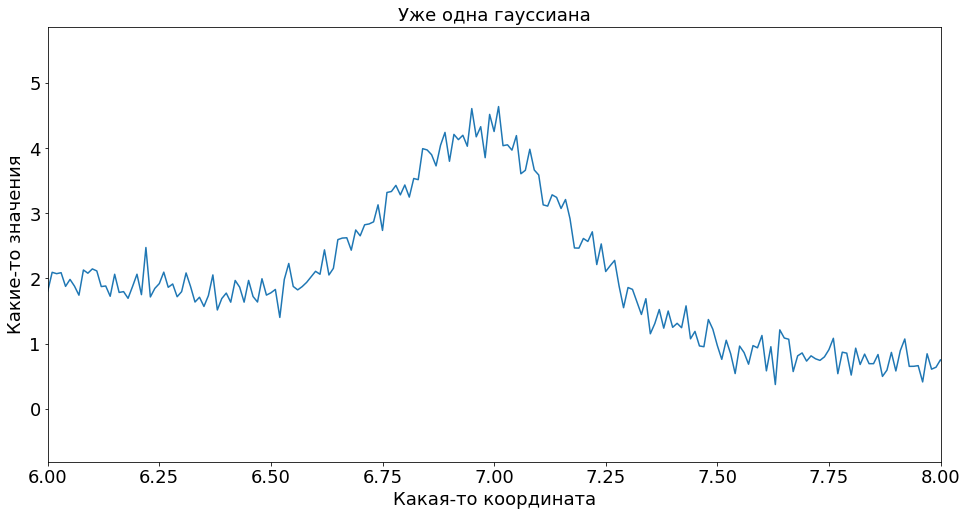

In [13]:
plt.figure(figsize=(16, 8))
plt.plot(x3, y3)
plt.title('Уже одна гауссиана', fontsize=18)
plt.ylabel('Какие-то значения', fontsize=18)
plt.xlabel('Какая-то координата', fontsize=18)
ax = plt.gca()
ax.tick_params(labelsize=18)
plt.xlim([6,8])
plt.show()

Не, ну на глаз где-то в районе семи... А если у нас таких гауссиан 50 картинок и нас интересует зависимость этого пика от времени? Что делать? 

Отставить панику, у нас же есть `curve_fit`!

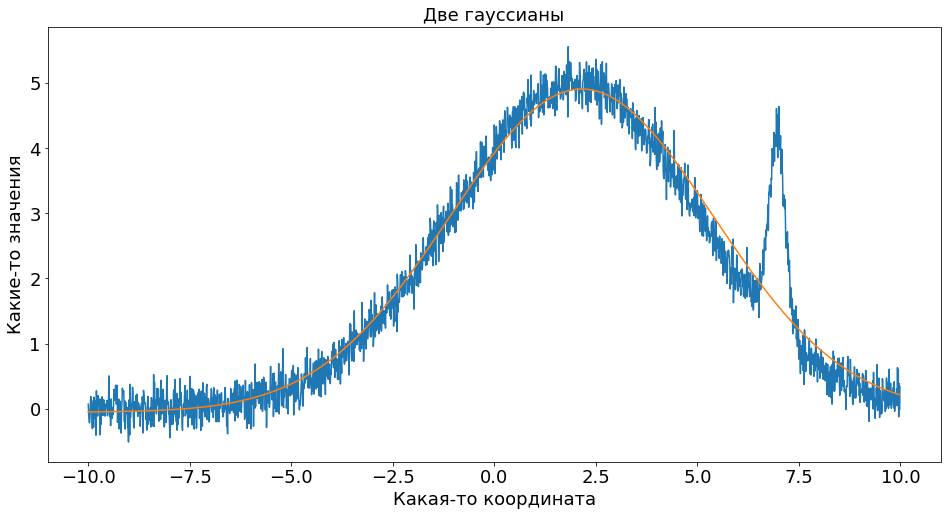

In [14]:
def gaussian(x, sigma, std_dev, amplitude, offset):
    return amplitude*np.exp(-1/2*((x - sigma)/std_dev)**2) + offset
p0 = [1, 1, 1, 0]   
params, pcov = curve_fit(gaussian, x3, y3, p0=p0)

plt.figure(figsize=(16, 8))
plt.plot(x3, y3, x3, gaussian(x3, *params))
plt.title('Две гауссианы', fontsize=18)
plt.ylabel('Какие-то значения', fontsize=18)
plt.xlabel('Какая-то координата', fontsize=18)
ax = plt.gca()
ax.tick_params(labelsize=18)
plt.show()

Oopsie-doopsie, нам же нужна была вторая гауссиана.... Что делать???? Лучше всего поменять модель:

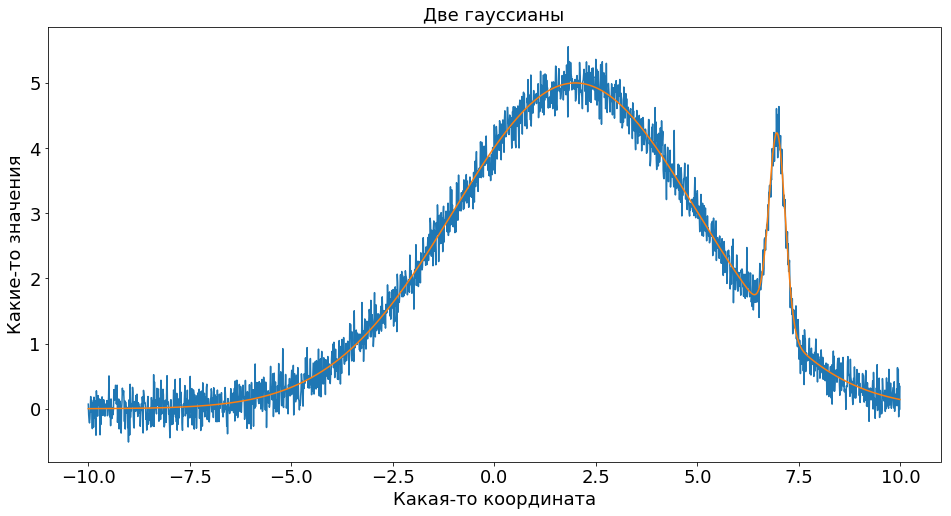

In [15]:
# алярм функция написана костыльно 
def gaussians(x, sigma1, sigma2, std_dev1, std_dev2, amplitude1, amplitude2, offset1, offset2):
    ret = 0
    ret += gaussian(x, sigma1, std_dev1, amplitude1, offset1)
    ret += gaussian(x, sigma2, std_dev2, amplitude2, offset2)
    return ret

p0 = [1,5, 2,2, 1,1, 0,0]   
params, pcov = curve_fit(gaussians, x3, y3, p0=p0)

plt.figure(figsize=(16, 8))
plt.plot(x3, y3, x3, gaussians(x3, *params))
plt.title('Две гауссианы', fontsize=18)
plt.ylabel('Какие-то значения', fontsize=18)
plt.xlabel('Какая-то координата', fontsize=18)
ax = plt.gca()
ax.tick_params(labelsize=18)
plt.show()


Теперь выглядит прямо супер! Так что давайте попробуем посмотреть что получилось. Нас интересует самый большой из двух первых элементов векторов параметров (самый большой из sigma1 или sigma2, нас же интересует именно вторая гауссиана, верно?):

In [21]:
params[:2]

array([1.99133755, 6.896764  ])

# Необязательная часть лекции

Возможно у вас мог возникнуть вопрос: а что сделать если гауссиан не две, а допустим три? Или вообще много? Что делать? Да и функция выглядит костыльно...

Для этого можно написать функцию остатков, она у нас будет называться gaussians и искать она будет разницу между данными и моделью, в нее же будет зашита модель. Только теперь нам неважно сколько у нас будет гауссиан, хоть 10! Но использовать теперь мы будем другую функцию, а именно [least_squares](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html). Прямая задача этой функции - искать минимум заданной функции:

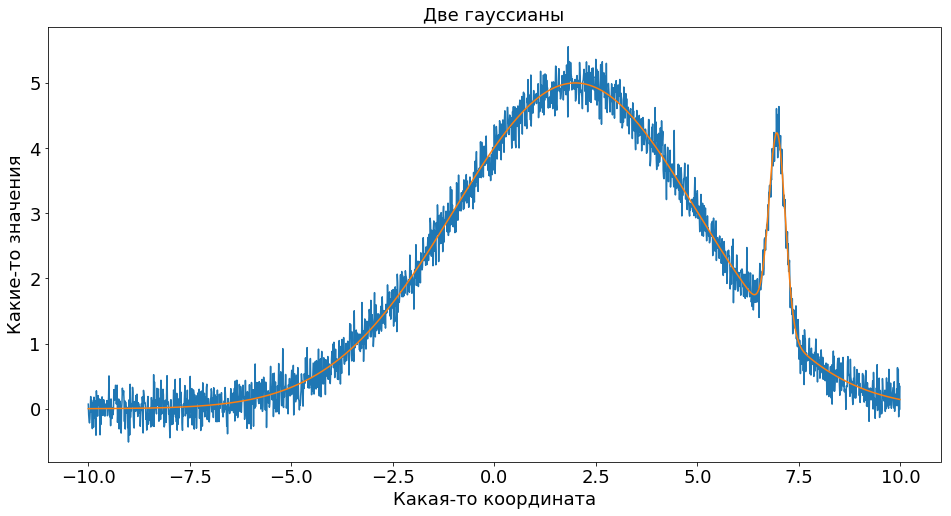

In [22]:
def gaussians(params, x, y):
    n = len(params)//4    # целочисленное деление 
    sigma = params[:n]    # смотрите: мы запихиваем в params кучу параметров и потом их распаковываем
    std_dev = params[n:2*n]
    amplitude = params[2*n:3*n]
    offset = params[3*n:]
    ret = 0
    for i in range(len(sigma)):
        ret += gaussian(x, sigma[i], std_dev[i], amplitude[i], offset[i])
    return ret - y

p0 = [2,5, 1,1, 3,3, 0,0]
# p0 = np.ones(8) # это работает плохо, все же начальное приближение должно быть неплохое
# p0 = np.ones(16) # а вот это уже ничего)
res_log = least_squares(gaussians, p0, args=(x3, y3))

plt.figure(figsize=(16, 8))
plt.plot(x3, y3, x3, gaussians(res_log.x, x3, y3)+y3)
plt.title('Две гауссианы', fontsize=18)
plt.ylabel('Какие-то значения', fontsize=18)
plt.xlabel('Какая-то координата', fontsize=18)
ax = plt.gca()
ax.tick_params(labelsize=18)
plt.show()

К слову в `res_log` хранится много чего интересного, посмотрите:

In [21]:
res_log

 active_mask: array([0., 0., 0., 0., 0., 0., 0., 0.])
        cost: 38.3334418705243
         fun: array([-0.06912467,  0.09434826,  0.18223195, ..., -0.23914263,
        0.15756971, -0.19969594])
        grad: array([-6.96843379e-08,  5.10026507e-06, -1.04275309e-07, -1.12951599e-05,
        1.07441032e-08,  8.96453356e-09,  1.17607253e-08, -7.22981675e-11])
         jac: array([[-0.00224061,  0.        ,  0.00896233, ...,  0.        ,
         1.        ,  1.        ],
       [-0.0022688 ,  0.        ,  0.00906752, ...,  0.        ,
         1.        ,  1.        ],
       [-0.00229732,  0.        ,  0.00917383, ...,  0.        ,
         1.        ,  1.        ],
       ...,
       [ 0.12879856,  0.        ,  0.34274774, ...,  0.        ,
         1.        ,  1.        ],
       [ 0.12781968,  0.        ,  0.34056917, ...,  0.        ,
         1.        ,  1.        ],
       [ 0.12684661,  0.        ,  0.33839961, ...,  0.        ,
         1.        ,  1.        ]])
     messag

А вообще, это проблема называется [`gaussian mixture model`](https://en.wikipedia.org/wiki/Mixture_model#Gaussian_mixture_model) и применяется для кластеризации данных в машинном обучении, только написана она, конечно, гораздо более аккуратно

# Лайфхаки
Иногда бывает очень важно померить время исполнения какого-то блока кода:

In [24]:
a = np.arange(1000)
%timeit a ** 2
%timeit [n**2 for n in a] # вот почему не нужно использовать циклы 

2.15 µs ± 575 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
325 µs ± 47.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Вот еще пример удачной векторизации:

In [25]:
%timeit np.sum(a ** 2)
%timeit np.vdot(a,a) # скалярное произведение для векторов

9.12 µs ± 1.75 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)
1.79 µs ± 114 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


Однако, это все не очень годится для больших участков кода, тут лучше использовать [профилирование](http://scipy-lectures.org/advanced/optimizing/index.html#profiler), там очень много разных вариантов на любой вкус и цвет.